# Homework part I

The first problem set contains basic tasks in pytorch.

__Note:__ Instead of doing this part of homework, you can prove your skills otherwise:
* A commit to pytorch or pytorch-based repos will do;
* Fully implemented seminar assignment in tensorflow or theano will do;
* Your own project in pytorch that is developed to a state in which a normal human can understand and appreciate what it does.

In [116]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
print(torch.__version__)

1.0.1.post2


### Task I - tensormancy

![img](https://media.giphy.com/media/3o751UMCYtSrRAFRFC/giphy.gif)

When dealing with more complex stuff like neural network, it's best if you use tensors the way samurai uses his sword. 


__1.1 the cannabola__ 
[_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (8 \cdot \theta) ) \cdot (1 + 0.1 \cdot cos(24 \cdot \theta)) \cdot (0.9 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (1 + sin(\theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

In [8]:
a = torch.FloatTensor([1, 2, 3, np.pi, 0])
a.cos()

tensor([ 0.5403, -0.4161, -0.9900, -1.0000,  1.0000])

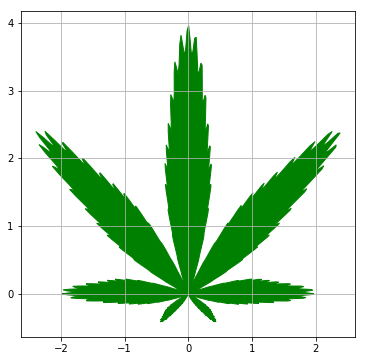

In [9]:
theta = torch.linspace(- np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1 + 0.9 * (8 * theta).cos()) * (1 + 0.1 * (24 * theta).cos()) * (0.9 + 0.05 * (200* theta).cos()) * (1 + theta.sin())

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = rho * theta.cos()
y = rho * theta.sin()


plt.figure(figsize=[6,6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

### Task II: the game of life

Now it's time for you to make something more challenging. We'll implement Conway's [Game of Life](http://web.stanford.edu/~cdebs/GameOfLife/) in _pure pytorch_. 

While this is still a toy task, implementing game of life this way has one cool benefit: __you'll be able to run it on GPU! __ Indeed, what could be a better use of your gpu than simulating game of life on 1M/1M grids?

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)
If you've skipped the url above out of sloth, here's the game of life:
* You have a 2D grid of cells, where each cell is "alive"(1) or "dead"(0)
* Any living cell that has 2 or 3 neighbors survives, else it dies [0,1 or 4+ neighbors]
* Any cell with exactly 3 neighbors becomes alive (if it was dead)

For this task, you are given a reference numpy implementation that you must convert to pytorch.
_[numpy code inspired by: https://github.com/rougier/numpy-100]_


__Note:__ You can find convolution in `torch.nn.functional.conv2d(Z,filters)`. Note that it has a different input format. 


In [32]:
from scipy.signal import correlate2d as conv2d

def np_update(Z):
    # Count neighbours with convolution
    filters = np.array([[1,1,1],
                        [1,0,1],
                        [1,1,1]])
    
    N = conv2d(Z,filters,mode='same')
    
    # Apply rules
    birth = (N==3) & (Z==0)
    survive = ((N==2) | (N==3)) & (Z==1)
    
    Z[:] = birth | survive
    return Z

In [53]:
a = torch.FloatTensor([[1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4]])
a.type(dtype=torch.LongTensor)

tensor([[1, 2, 3, 4],
        [1, 2, 3, 4],
        [1, 2, 3, 4]])

In [54]:
def torch_update(Z):
    """
    Implement an update function that does to Z exactly the same as np_update.
    :param Z: torch.FloatTensor of shape [height,width] containing 0s(dead) an 1s(alive)
    :returns: torch.FloatTensor Z after updates.
    
    You can opt to create new tensor or change Z inplace.
    """
    Z = Z.reshape((1, 1) + Z.size())
    filters = torch.FloatTensor([[[[1,1,1],
                                 [1,0,1],
                                 [1,1,1]]]])
    N = F.conv2d(Z, filters, padding=1)
    Z = Z.squeeze()
    N = N.squeeze()
    birth = (N==3) & (Z==0)
    survive = ((N==2) | (N==3)) & (Z==1)
    Z = birth | survive
    return Z.type(torch.FloatTensor)


In [55]:
#initial frame
Z_numpy = np.random.choice([0,1],p=(0.5,0.5),size=(100,100))
Z = torch.from_numpy(Z_numpy).type(torch.FloatTensor)

#your debug polygon :)
Z_new = torch_update(Z.clone())

#tests
Z_reference = np_update(Z_numpy.copy())
assert np.all(Z_new.numpy() == Z_reference), "your pytorch implementation doesn't match np_update. Look into Z and np_update(ZZ) to investigate."
print("Well done!")

Well done!


<IPython.core.display.Javascript object>


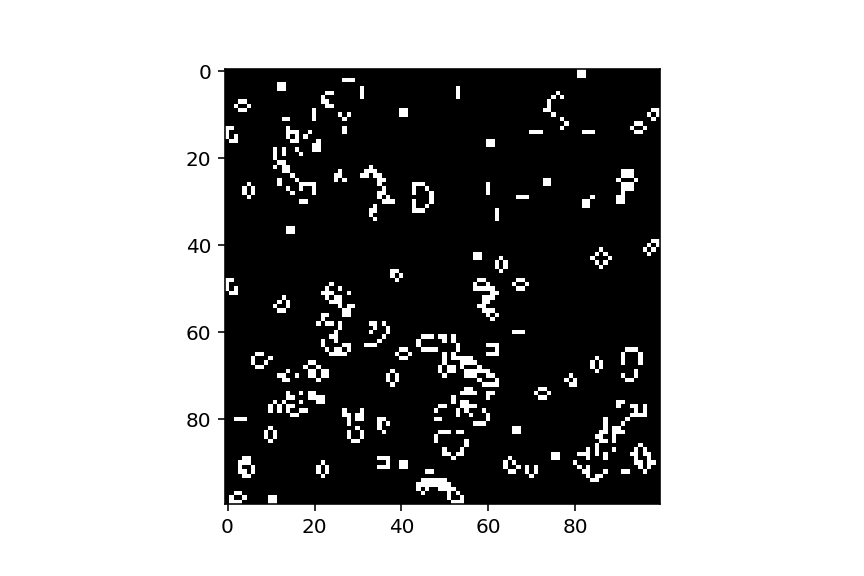

In [58]:
%matplotlib notebook
plt.ion()

#initialize game field
Z = np.random.choice([0,1],size=(100,100))
Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    
    #update
    Z = torch_update(Z)
    
    #re-draw image
    ax.clear()
    ax.imshow(Z.numpy(),cmap='gray')
    fig.canvas.draw()


<IPython.core.display.Javascript object>


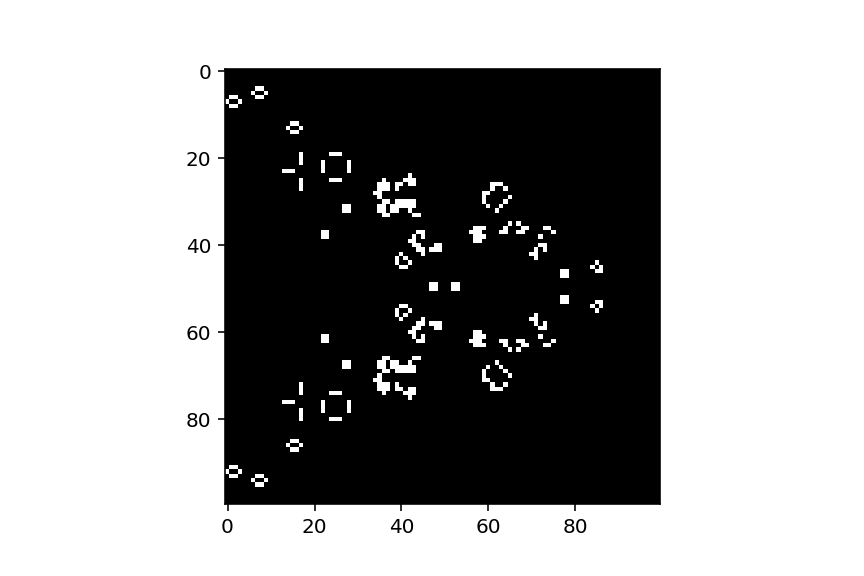

In [60]:
#Some fun setups for your amusement

#parallel stripes
Z = np.arange(100)%2 + np.zeros([100,100])
#with a small imperfection
Z[48:52,50]=1

Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    Z = torch_update(Z)
    ax.clear()
    ax.imshow(Z.numpy(),cmap='gray')
    fig.canvas.draw()

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE)

```

```

```

```

```

```

```

```

```

```



### Task III: Going deeper
<img src="http://download.gamezone.com/uploads/image/data/1190338/article_post_width_a88.jpg" width=360>
Your third trial is to build your first neural network [almost] from scratch and pure torch.

This time you will solve yet another digit recognition problem, but at a greater scale
* 10 different letters
* 20k samples

We want you to build a network that reaches at least 80% accuracy and has at least 2 linear layers in it. Naturally, it should be nonlinear to beat logistic regression. You can implement it with either 


With 10 classes you will need to use __Softmax__ at the top instead of sigmoid and train for __categorical crossentropy__  (see [here](https://www.kaggle.com/wiki/LogLoss)).  Write your own loss or use `torch.nn.functional.nll_loss`. Just make sure you understand what it accepts as an input.

Note that you are not required to build 152-layer monsters here. A 2-layer (one hidden, one output) neural network should already give you an edge over logistic regression.


__[bonus kudos]__
If you've already beaten logistic regression with a two-layer net, but enthusiasm still ain't gone, you can try improving the test accuracy even further! It should be possible to reach 90% without convnets.

__SPOILERS!__
At the end of the notebook you will find a few tips and frequent errors. 
If you feel confident enogh, just start coding right away and get there ~~if~~ once you need to untangle yourself. 



In [61]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

Extracting ...
Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


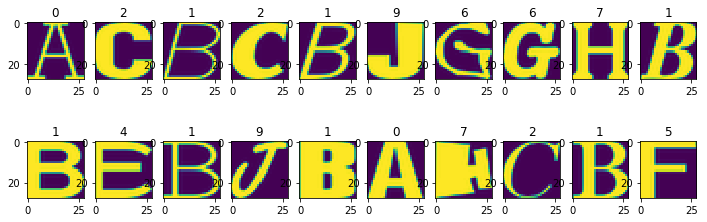

In [62]:
%matplotlib inline
plt.figure(figsize=[12,4])
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(X_train[i].reshape([28,28]))
    plt.title(str(y_train[i]))

In [ ]:
#< a whole lot of your code > 

In [66]:
from tqdm import tqdm

In [63]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((14043, 784), (14043,), (4681, 784), (4681,))

In [64]:
def iterate_minibatch(X, y, batch_size, shuffle=True):
    ind = np.arange(X.shape[0])
    if shuffle:
        ind = np.random.permutation(ind)
    for batch_start in range(0, ind.shape[0], batch_size):
        batch_ind = ind[batch_start:batch_start + batch_size]
        yield X[batch_ind], y[batch_ind]

In [89]:
log_reg = nn.Sequential(nn.Linear(784, 10), nn.LogSoftmax())
for m in log_reg:
    if isinstance(m, nn.Linear):
        print('ok')
        nn.init.xavier_uniform_(m.weight)
cuda = torch.device('cuda')
with torch.cuda.device(1):
    log_reg_gpu = log_reg.cuda()
    opt = torch.optim.Adam(log_reg_gpu.parameters(), lr=0.01)

ok


In [90]:
from IPython.display import clear_output

In [91]:
a = torch.tensor([1,1,1])
a.detach().numpy()

array([1, 1, 1])

In [102]:
loss_hist = []
val_metric = []

100%|██████████| 10/10 [00:00<00:00, 23.06it/s]


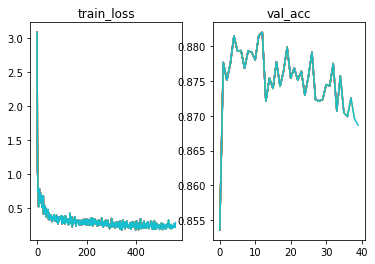

In [96]:
for epoch in tqdm(range(10)):
    for X, y in iterate_minibatch(X_train, y_train, batch_size=1024, shuffle=True):
        with torch.cuda.device(1):
            x_torch = torch.tensor(X, device=cuda)
            y_torch = torch.tensor(y, device=cuda)
        y_pred = log_reg_gpu(x_torch)
        loss = F.nll_loss(y_pred, y_torch)
        loss_hist.append(loss.detach().cpu().numpy())
        loss.backward()
        opt.step()
        opt.zero_grad()
    accuracy = 0.0
    cnt = 0.0
    for X, y in iterate_minibatch(X_test, y_test, batch_size=1024, shuffle=False):
        with torch.cuda.device(1):
            x_torch = torch.tensor(X, device=cuda)
        y_pred = log_reg_gpu(x_torch)
        prediction = y_pred.detach().cpu().numpy().argmax(axis=1)
        acc = np.mean(y == prediction)
        accuracy += acc
        cnt += 1.0
    val_metric.append(accuracy / cnt)
    
    clear_output(True)
    plt.subplot(1, 2, 1)
    plt.plot(loss_hist)
    plt.title('train_loss')
    plt.subplot(1, 2, 2)
    plt.plot(val_metric)
    plt.title('val_acc')

In [97]:
np.max(val_metric)

0.8819761618589744

In [100]:
784 /2 /2/2/2

49.0

In [101]:
super_net = nn.Sequential(nn.Linear(784, 392), nn.LeakyReLU(),
                          nn.Linear(392, 196), nn.LeakyReLU(),
                          nn.Linear(196, 49), nn.LeakyReLU(),
                          nn.Linear(49, 10), nn.LogSoftmax())
for m in super_net:
    if isinstance(m, nn.Linear):
        print('ok')
        nn.init.xavier_uniform_(m.weight)
with torch.cuda.device(1):
    super_net_gpu = super_net.cuda()
    opt = torch.optim.Adam(super_net_gpu.parameters(), lr=0.001)

ok
ok
ok
ok


In [103]:
loss_hist = []
val_metric = []

100%|██████████| 100/100 [00:07<00:00, 14.13it/s]


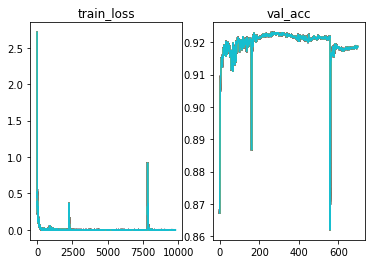

In [113]:
for epoch in tqdm(range(100)):
    for X, y in iterate_minibatch(X_train, y_train, batch_size=1024, shuffle=True):
        with torch.cuda.device(1):
            x_torch = torch.tensor(X, device=cuda)
            y_torch = torch.tensor(y, device=cuda)
        y_pred = super_net_gpu(x_torch)
        loss = F.nll_loss(y_pred, y_torch)
        loss_hist.append(loss.detach().cpu().numpy())
        loss.backward()
        opt.step()
        opt.zero_grad()
    accuracy = 0.0
    cnt = 0.0
    for X, y in iterate_minibatch(X_test, y_test, batch_size=1024, shuffle=False):
        with torch.cuda.device(1):
            x_torch = torch.tensor(X, device=cuda)
        y_pred = super_net_gpu(x_torch)
        prediction = y_pred.detach().cpu().numpy().argmax(axis=1)
        acc = np.mean(y == prediction)
        accuracy += acc
        cnt += 1.0
    val_metric.append(accuracy / cnt)
    
    clear_output(True)
    plt.subplot(1, 2, 1)
    plt.plot(loss_hist)
    plt.title('train_loss')
    plt.subplot(1, 2, 2)
    plt.plot(val_metric)
    plt.title('val_acc')

In [114]:
np.max(val_metric)

0.9230919471153847

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```


# SPOILERS!

Recommended pipeline

* Adapt logistic regression from week2 seminar assignment to classify one letter against others (e.g. A vs the rest)
* Generalize it to multiclass logistic regression.
  - Either try to remember lecture 0 or google it.
  - Instead of weight vector you'll have to use matrix (feature_id x class_id)
  - softmax (exp over sum of exps) can implemented manually or as nn.Softmax (layer) F.softmax (function)
  - probably better to use STOCHASTIC gradient descent (minibatch) for greater speed
    - you can also try momentum/rmsprop/adawhatever
    - in which case sample should probably be shuffled (or use random subsamples on each iteration)
* Add a hidden layer. Now your logistic regression uses hidden neurons instead of inputs.
  - Hidden layer uses the same math as output layer (ex-logistic regression), but uses some nonlinearity (e.g. sigmoid) instead of softmax
  - You need to train both layers, not just output layer :)
  - __Do not initialize weights with zeros__ (due to symmetry effects). A gaussian noize with small variance will do.
  - 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve. 
  - In ideal casae this totals to 2 .dot's, 1 softmax and 1 sigmoid
  - __make sure this neural network works better than logistic regression__
  
* Now's the time to try improving the network. Consider layers (size, neuron count),  nonlinearities, optimization methods, initialization - whatever you want, but please avoid convolutions for now.
  
* If anything seems wrong, try going through one step of training and printing everything you compute.
* If you see NaNs midway through optimization, you can estimate log P(y|x) as via F.log_softmax(layer_before_softmax)

